In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# 데이터 분포 확인을 위한 plt 라이브러리 import 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

In [25]:
df['order_id'].value_counts()[lambda x: x >= 2]


order_id
df56136b8031ecd28e200bb18e6ddb2e    3
03c939fd7fd3b38f8485a0f95798f1f6    3
c88b1d1b157a9999ce368f218a407141    3
8e17072ec97ce29f0e1f111e598b0c85    3
bbf6a647ecc68aa5e79d2cd75ef44c68    2
                                   ..
66f943fd426ac8716ef6b6b97ace8bd8    2
76de574e14e58baded25a12dce8075c1    2
2fcdb0c004a2a538d3dd724ea76916bd    2
dbfa3d8c05cc5d84083fc259a9feb5bc    2
79ce3a0a9eba49ff442b392ab05349a4    2
Name: count, Length: 547, dtype: int64

In [3]:
# 주문 + 리뷰
df = orders.merge(
    reviews[["order_id", "review_score"]],
    on="order_id",
    how="left"
)
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,5.0
...,...,...,...,...,...,...,...,...,...
99987,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,5.0
99988,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,4.0
99989,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,5.0
99990,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0


In [ ]:
## 주문 아이템 요약 (주문 구조)
order_item_summary = (
    order_items
    .groupby("order_id")
    .agg(
        n_items=("order_item_id", "count"),  # 주문 상품 수
        n_sellers=("seller_id", "nunique"),  # 판매자 수
        total_price=("price", "sum"),  # 주문 금액
        total_freight=("freight_value", "sum")  # 배송비
    )
    .reset_index()
)

df = df.merge(order_item_summary, on="order_id", how="left")
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,n_items,n_sellers,total_price,total_freight
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4.0,1.0,1.0,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,4.0,1.0,1.0,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,5.0,1.0,1.0,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,5.0,1.0,1.0,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,5.0,1.0,1.0,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,5.0,1.0,1.0,72.00,13.08
99988,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,4.0,1.0,1.0,174.90,20.10
99989,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,5.0,1.0,1.0,205.99,65.02
99990,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,2.0,1.0,359.98,81.18


In [ ]:
## 결제 정보 요약
payment_summary = (
    payments
    .groupby("order_id")
    .agg(
        payment_type=("payment_type", lambda x: x.mode()[0]),  # 같은 주문 안에서 가장 많이 사용된 결제 수단을 대표로
        n_payments=("payment_sequential", "max"),  # 한 주문에서 총 몇 번에 나눠서 결제됐는지
        total_payment=("payment_value", "sum")     # 한 주문의 결제 금액
    )
    .reset_index()
)

df = df.merge(payment_summary, on="order_id", how="left")
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,n_items,n_sellers,total_price,total_freight,payment_type,n_payments,total_payment
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4.0,1.0,1.0,29.99,8.72,voucher,3.0,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,4.0,1.0,1.0,118.70,22.76,boleto,1.0,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,5.0,1.0,1.0,159.90,19.22,credit_card,1.0,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,5.0,1.0,1.0,45.00,27.20,credit_card,1.0,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,5.0,1.0,1.0,19.90,8.72,credit_card,1.0,28.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,5.0,1.0,1.0,72.00,13.08,credit_card,1.0,85.08
99988,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,4.0,1.0,1.0,174.90,20.10,credit_card,1.0,195.00
99989,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,5.0,1.0,1.0,205.99,65.02,credit_card,1.0,271.01
99990,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,2.0,1.0,359.98,81.18,credit_card,1.0,441.16


In [7]:
## 배송 지연 변수 생성
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [ ]:
df["delivery_delay_days"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

df["is_late"] = (df["delivery_delay_days"] > 0).astype(int)


In [ ]:
## 저평점 정의
df["low_review"] = (df["review_score"] <= 2).astype(int)

In [27]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1793
order_delivered_customer_date    2987
order_estimated_delivery_date       0
review_score                      768
n_items                           778
n_sellers                         778
total_price                       778
total_freight                     778
payment_type                        1
n_payments                          1
total_payment                       1
delivery_delay_days              2987
is_late                             0
low_review                          0
freight_ratio                     778
dtype: int64

In [34]:
df["delivery_completed"].unique()

array([1, 0])

In [ ]:
df["delivery_completed"] = df["delivery_delay_days"].notna().astype(int)
df2 = df[df["delivery_completed"] == 1].copy()
df2 = df2[df2["review_score"].notna()]
df2.isna().sum()


order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      1
order_delivered_customer_date     0
order_estimated_delivery_date     0
review_score                      0
n_items                           0
n_sellers                         0
total_price                       0
total_freight                     0
payment_type                      1
n_payments                        1
total_payment                     1
delivery_delay_days               0
is_late                           0
low_review                        0
freight_ratio                     0
delivery_completed                0
dtype: int64

In [42]:
df2.dropna(inplace=True)

#### 기본 분포 확인

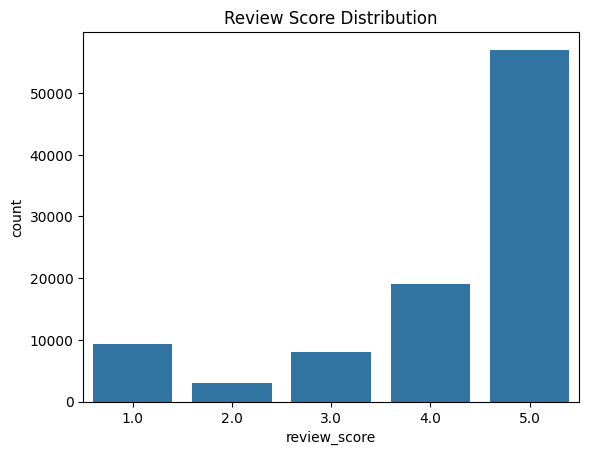

In [43]:
## 리뷰 점수 분포
sns.countplot(data=df2, x="review_score")
plt.title("Review Score Distribution")
plt.show()

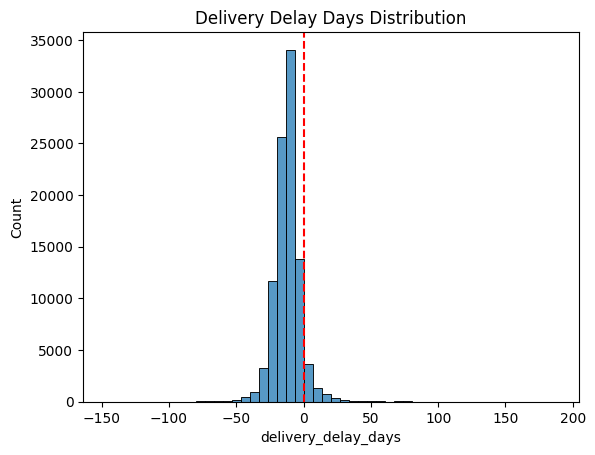

In [44]:
## 배송 지연 분포
sns.histplot(df2["delivery_delay_days"].dropna(), bins=50)
plt.axvline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days Distribution")
plt.show()

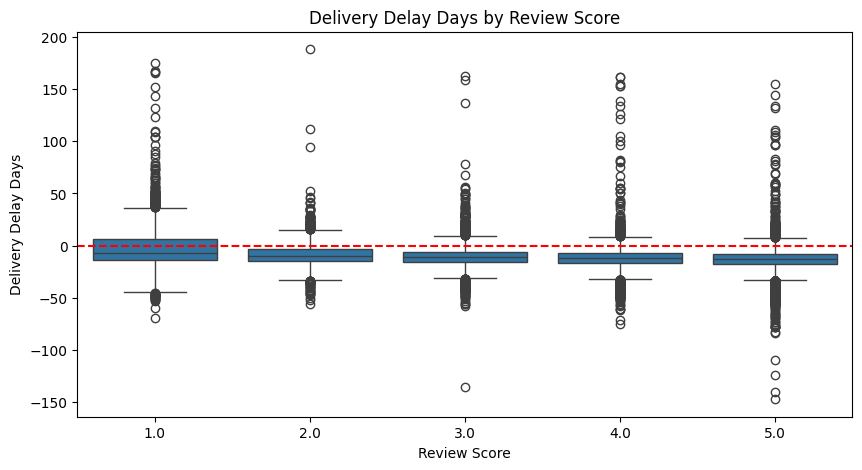

In [45]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df2,
    x="review_score",
    y="delivery_delay_days"
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Delivery Delay Days")
plt.show()


**1. 저평점 (1~2점)**
- 50일, 100일 이상 지연된 점들 상대적으로 많다고 볼 수 있나?

**2. 고평점 (4~5점)**
- 지연 사례는 존재함
- 극단적 지연 빈도는 ...??


#### 문제 요인별 EDA (리뷰 전 감지 가능 변수)

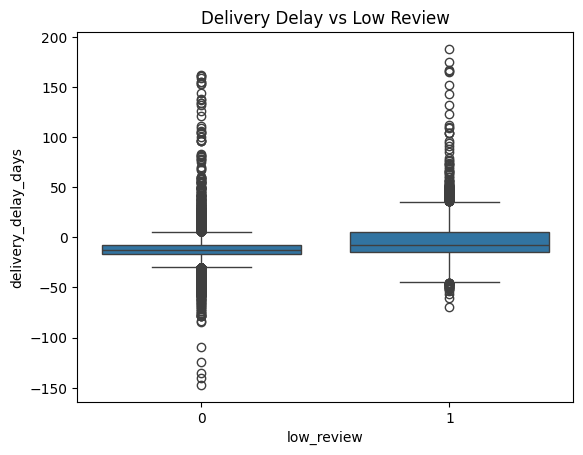

In [46]:
## 배송 지연 vs 리뷰
sns.boxplot(
    data=df2,
    x="low_review",
    y="delivery_delay_days"
)
plt.title("Delivery Delay vs Low Review")
plt.show()


In [47]:
df2.groupby("is_late")["low_review"].mean()

is_late
0    0.092834
1    0.624064
Name: low_review, dtype: float64

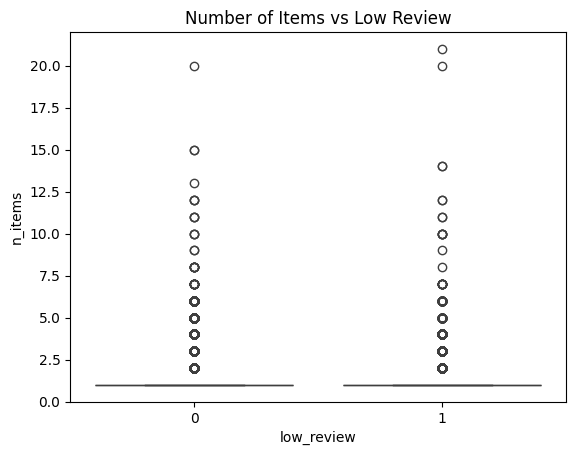

In [50]:
## 주문 구조 (아이템 수, 판매자 수)
sns.boxplot(data=df, x="low_review", y="n_items")
plt.title("Number of Items vs Low Review")
plt.show()


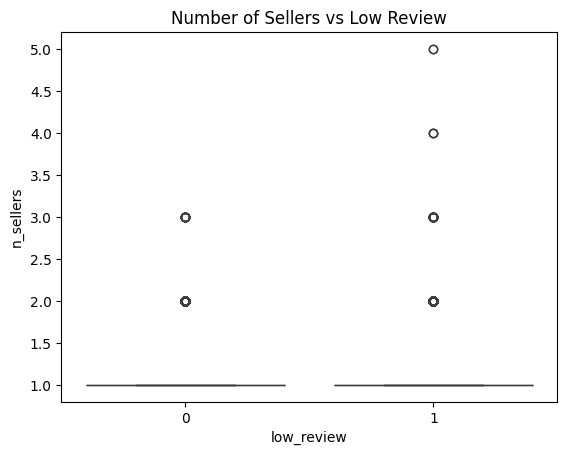

In [51]:
sns.boxplot(data=df, x="low_review", y="n_sellers")
plt.title("Number of Sellers vs Low Review")
plt.show()


대부분의 주문은 단일 판매자로 구성되지만,
복수 판매자가 포함된 주문의 경우 저평점으로 이어질 가능성이 상대적으로 더 높게 나타나는 듯??

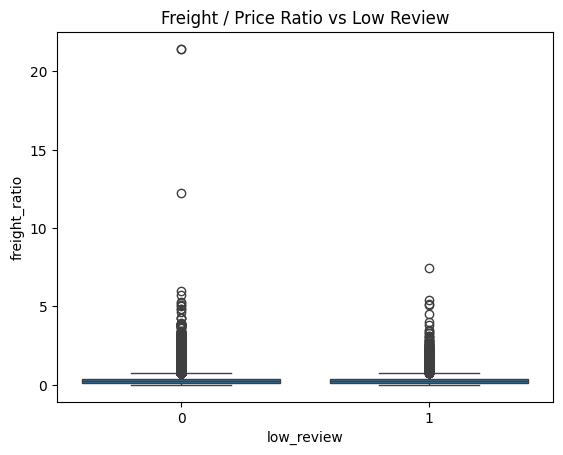

In [52]:
## 배송비 부담
df["freight_ratio"] = df["total_freight"] / df["total_price"]

sns.boxplot(data=df, x="low_review", y="freight_ratio")
plt.title("Freight / Price Ratio vs Low Review")
plt.show()


- 배송비 비중이 높을수록 무조건 저평점은 아님

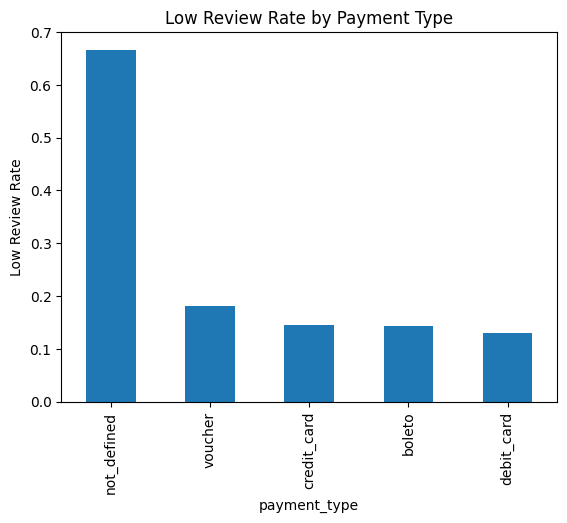

In [53]:
## 결제 수단
payment_review = (
    df.groupby("payment_type")["low_review"]
    .mean()
    .sort_values(ascending=False)
)

payment_review.plot(kind="bar")
plt.title("Low Review Rate by Payment Type")
plt.ylabel("Low Review Rate")
plt.show()


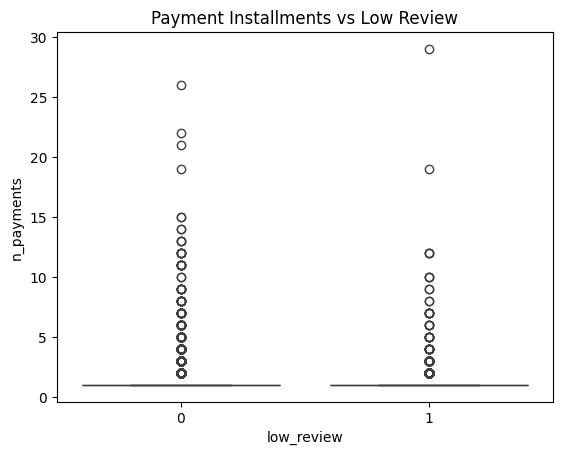

In [54]:
## 분할 결제 여부
sns.boxplot(data=df, x="low_review", y="n_payments")
plt.title("Payment Installments vs Low Review")
plt.show()


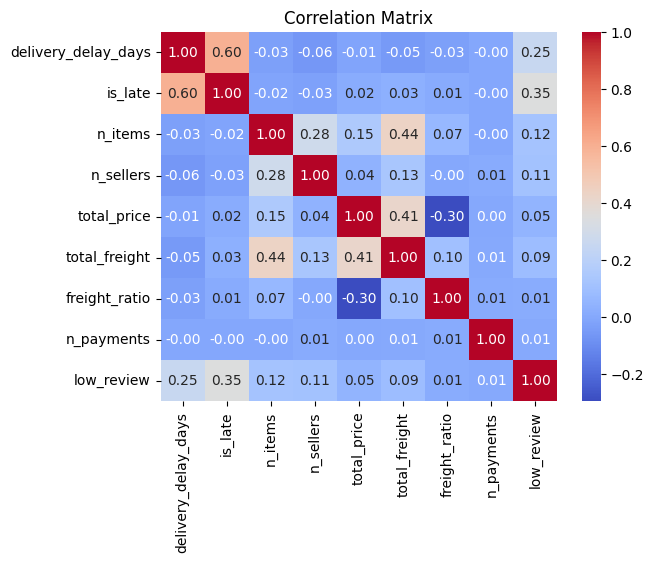

In [55]:
## 상관 구조
feature_cols = [
    "delivery_delay_days",
    "is_late",
    "n_items",
    "n_sellers",
    "total_price",
    "total_freight",
    "freight_ratio",
    "n_payments",
    "low_review"
]

corr = df[feature_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
